## 📖 **Introduction**

In today’s customer-centric aviation industry, maintaining a strong reputation and delivering high-quality service are essential for airlines to stay competitive. One powerful way to assess and improve service is by analyzing customer feedback found on public platforms like [AirlineQuality.com](https://www.airlinequality.com). These platforms contain thousands of reviews — rich in insight, yet unstructured and hard to interpret without the help of data science.

This project is part of **Task 0** from the **British Airways Data Science Virtual Internship** on [Forage](https://www.theforage.com/simulations/british-airways/data-science-yqoz), simulating a real-world scenario where the airline wants to mine online reviews to uncover patterns, sentiments, and key areas of customer satisfaction or dissatisfaction.

The project also serves as a capstone-style exercise to apply practical skills gained from completing multiple **NLP-focused courses** within the [Machine Learning Scientist career track on DataCamp](https://app.datacamp.com/learn/career-tracks/machine-learning-scientist-with-python).

---

### 🎯 **Project Goals**

#### 🧑🏽‍💼 Business Goals

* Understand what British Airways is doing well and where customer satisfaction is low.
* Identify key pain points in the travel experience based on recurring themes in reviews.
* Generate actionable insights to inform service improvements, customer communication, and brand strategy.
* Present findings in a clear and concise 1–2 slide summary for decision-makers.

#### 📊 Data Science Goals

* Collect and structure raw textual review data from a public website using web scraping.
* Clean and preprocess unstructured text using standard NLP techniques.
* Apply sentiment analysis and topic modeling to detect themes and emotional tones.
* Visualize and interpret review content to extract meaning and trends.
* Translate insights into business-oriented recommendations.

---

### 🛠️ **Tools & Technologies**

| Area                         | Tools                                                             |
| ---------------------------- | ----------------------------------------------------------------- |
| **Web Scraping**             | `requests`, `BeautifulSoup`                                       |
| **Data Handling**            | `pandas`, `numpy`                                                 |
| **Text Preprocessing**       | `nltk`, `spaCy`                                                   |
| **Sentiment Analysis**       | `TextBlob`, `VADER`                                               |
| **Keyword & Topic Modeling** | `CountVectorizer`, `TfidfVectorizer`, `LatentDirichletAllocation` |
| **Visualization**            | `matplotlib`, `seaborn`, `WordCloud`                              |
| **Presentation**             | Canva (or optionallay PowerPoint, Google slides)                  |

### Importing Libraries and Loading Dataset

In [2]:
# Miscellaneous
from pathlib import Path

# Base directory = location of the current script or notebook
base_dir = Path().resolve()

In [3]:
# Data Wrangling and Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text Preprocessing
import re
import nltk
# NLTK data path
nltk_data_path = base_dir / "nltk_data"
nltk.data.path.append(str(nltk_data_path))
import spacy

# Text Analysis
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from wordcloud import WordCloud
from collections import Counter
import gensim
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis


print("✅ All packages successfully loaded!")

✅ All packages successfully loaded!


In [4]:
default_stopwords = text.ENGLISH_STOP_WORDS

In [5]:
# Load the custom lexicon manually
def load_custom_vader_lexicon(path):
    lexicon = {}
    with open(path, encoding='utf-8') as f:
        for line in f:
            if not line.strip() or line.startswith("#"):
                continue
            word, measure = line.strip().split('\t')[0:2]
            lexicon[word] = float(measure)
    return lexicon

# Create an uninitialized instance (bypass __init__)
sia = SentimentIntensityAnalyzer.__new__(SentimentIntensityAnalyzer)

# Vader lexicon path
vader_lexicon_path = nltk_data_path / "sentiment" / "lexicon" / "vader_lexicon.txt"

# Inject required attributes manually
sia.lexicon = load_custom_vader_lexicon(str(vader_lexicon_path))

# Copy default constants
from nltk.sentiment.vader import VaderConstants
sia.constants = VaderConstants()

# Now test
print(sia.polarity_scores("I love how clean and comfortable the flight was."))


{'neg': 0.0, 'neu': 0.329, 'pos': 0.671, 'compound': 0.8807}


In [6]:
# Loading dataset
raw_reviews_path = base_dir / "data" / "british_airways_reviews.csv"

df_reviews = pd.read_csv(raw_reviews_path)

In [7]:
df_reviews.sample(20)

,reviews
1267,✅ Trip Verified | Los Angeles to London Heath...
1313,✅ Trip Verified | London to Munich. The groun...
915,✅ Trip Verified | My husband and I used Briti...
2223,✅ Verified Review | First leg DUS to LHR was ...
298,✅ Trip Verified | Check in and security cleara...
3386,LHR-LAX-LHR Economy. Both legs on lower deck o...
2663,Milan Linate to London Heathrow on December th...
1997,✅ Verified Review | Flew from Lisbon to Londo...
1082,✅ Trip Verified | Gatwick to Glasgow. Awful e...
1164,Not Verified | Larnaca to London. This A320 i...


In [8]:
df_reviews.shape

(3949, 1)

# 🧼 **Pre-Data Cleaning**

Before proceeding with full text preprocessing, I performed a **pre-cleaning step** to prepare the raw dataset for analysis. This was based on a quick review of the scraped data to remove noise and ensure better quality results in subsequent NLP tasks.

The following actions were taken:

1. **Filtering out unverified reviews**:
Some reviews began with the phrase *“Not Verified”*, indicating that the reviewer’s travel experience could not be confirmed. To ensure the analysis reflects genuine customer experiences, all such reviews were excluded from the dataset.

2. **Removing verification tags from review text**:
   Many verified reviews began with tags like **“✅ Trip Verified |”** or **“✅ Verified Review |”** embedded in the review text itself. These were stripped out to avoid skewing keyword frequency, sentiment scores, and topic modeling results.

3. **Removing duplicates**:
   Duplicated reviews were identified and removed completely.


In [9]:
df_reviews.sample(20)

,reviews
2073,✅ Verified Review | London Heathrow to Brusse...
2092,❎ Unverified | London Heathrow to San Francis...
1828,✅ Verified Review | Rome to Heathrow flight o...
1574,✅ Trip Verified | Flew British Airways from Ba...
282,Not Verified | Booked a very special holiday ...
3371,LHR-CDG return. The outbound flight was ok. No...
843,✅ Trip Verified | Mumbai to London Heathrow. ...
1024,✅ Trip Verified | London to St Petersburgh. H...
1989,"✅ Verified Review | No, no, no, British Airway..."
3264,NCL-LHR return. Great alternative to rail trav...


### 1. Identifying and removing unverified trips

In [10]:
# Define pattern for unverified reviews
unverified_pattern = r'^(?:❎\s*)?(?:Unverified|Not Verified)\s*\|\s*'

# Identify unverified reviews
unverified_reviews = df_reviews[df_reviews['reviews'].str.contains(unverified_pattern, case=False, na=False, regex=True)]

print(f"There are {len(unverified_reviews)} unverified reviews in the dataset.")

There are 320 unverified reviews in the dataset.


In [11]:
unverified_reviews.sample(5)

,reviews
126,Not Verified | I reported my damaged/ruined ...
858,Not Verified | Gatwick to Malaga. Nothing spe...
230,Not Verified | Beware! BA don't provide any r...
889,Not Verified | British Airways (Comair) Johan...
489,Not Verified | It seems that there is a race t...


In [12]:
# Filter out unverified reviews
df_reviews = df_reviews[~df_reviews.index.isin(unverified_reviews.index)].copy()

In [13]:
# Reporting
total_reviews = len(df_reviews) + len(unverified_reviews)
removed_count = len(unverified_reviews)
remaining_count = len(df_reviews)
percent_removed = (removed_count / total_reviews) * 100

print(f"Before removing unverified reviews, the dataset had {total_reviews} rows.")
print(f"After removing {removed_count} unverified reviews, the dataset has {remaining_count} rows.")
print(f"Percentage of unverified reviews removed: {percent_removed:.0f}%")

Before removing unverified reviews, the dataset had 3949 rows.
After removing 320 unverified reviews, the dataset has 3629 rows.
Percentage of unverified reviews removed: 8%


### 2. Removing verification tags from texts

In [14]:
# Striping the "✅ Trip Verified" and ✅ Verified Review | parts including the pipe symbol and any leading spaces
df_reviews['reviews'] = df_reviews['reviews'].str.replace(r"^✅ (Trip Verified|Verified Review)\s*\|\s*", "", regex=True)

In [15]:
df_reviews.sample(5)

,reviews
3800,Flew YYZ to LHR on 1st July. Booked WT+ but wa...
2046,I have flown a lot with British Airways and ot...
520,Disappointing again especially on business. Th...
3351,LHR-SOF-LHR 27th Feb/2nd Mar Seat A1 on an A32...
3367,I fly BA business regularly between Delhi and ...


### 3. Check and remove duplicates

In [16]:
# Check duplicate reviews
duplicate_reviews = df_reviews[df_reviews.duplicated(subset='reviews', keep=False)]
print(f"There are {len(duplicate_reviews)} duplicate reviews in the dataset.")

There are 42 duplicate reviews in the dataset.


In [17]:
# Remove duplicate reviews
df_reviews = df_reviews.drop_duplicates(subset='reviews', keep='first').reset_index(drop=True)

In [18]:
# Check if duplicates are removed
remaining_duplicates = df_reviews[df_reviews.duplicated(subset='reviews', keep=False)]
print(f"After removing duplicates, there are {len(remaining_duplicates)} duplicate reviews left in the dataset.")

After removing duplicates, there are 0 duplicate reviews left in the dataset.


In [ ]:
# save the cleaned dataset to a new CSV file
cleaned_reviews_path = base_dir / "data" / "british_airways_reviews_cleaned.csv"
#df_reviews.to_csv(cleaned_reviews_path, index=False)

# 🧹 **Text Preprocessing**

In this step, the review text data was preprocessed to prepare it for analysis. The goal was to clean and standardize the text, reducing noise and ensuring consistency across the dataset.

The following actions were performed:

1. **Lowercasing**
   All review texts were converted to lowercase to ensure uniformity and avoid treating the same words with different casing as separate tokens.

2. **Removal of punctuation, digits, and stopwords**
   Punctuation marks, numbers, and common stopwords (e.g., *"the"*, *"and"*, *"is"*) were removed to focus the analysis on meaningful content.

3. **Tokenization and Lemmatization**
   The text was split into individual tokens (words), and each word was lemmatized (reduced to its base or dictionary form) to improve consistency and reduce redundancy.

4. **Location extraction (where available)**
   Some reviews included route information such as flight origin and destination (e.g., *"London to New York"*). Where present, these were extracted and processed into separate **origin** and **destination** columns to support location-based insights.


In [20]:
# Loading the cleaned dataset
reviews_cleaned = pd.read_csv(cleaned_reviews_path)

In [21]:
reviews_cleaned.sample(10)

,reviews
3223,London Gatwick - Barbados in premium economy. ...
483,British Airways are in the process of upgradin...
2006,Paris to Bangkok via London. What a mistake to...
312,Absolutely horrible experience. I booked a tic...
2165,MAN to LHR with personable crew who did the br...
3329,Orlando Florida (MCO) - London Gatwick (LGW). ...
3134,LIS-LHR-VIE on Dec. 8 both legs on an Airbus 3...
1230,Chicago to Chennai via London. The pilot and c...
2636,"I fly about 1-2 times a month, 90% of the time..."
775,London to Glasgow. BA customer service is unqu...


In [22]:
# 1. Convert all the texts to lowercases
reviews_cleaned['text_lowercased'] = reviews_cleaned['reviews'].str.lower()

In [23]:
# Load English language model
nlp = spacy.load("en_core_web_sm")

In [24]:
# 2. Extract route information from the reviews
# Function to extract origin and destination using spaCy NER and regex rules
def extract_route_with_ner_and_rules(text):
    doc = nlp(text)
    text_clean = text.strip()

    # Extract all GPE locations with their position
    gpe_locs = [(ent.start_char, ent.end_char, ent.text) for ent in doc.ents if ent.label_ == "GPE"]
    unique_locs = list(dict.fromkeys([loc[2] for loc in gpe_locs]))  # Deduplicate, keep order

    origin, dest = None, None

    # 1. Check for "from ... to ..." pattern
    match_from_to = re.search(r'\bfrom\s+([A-Z][\w\s&\-]+?)\s+(?:\w+\s+)*to\s+([A-Z][\w\s&\-]+)', text_clean)
    if match_from_to:
        origin = match_from_to.group(1).strip()
        dest = match_from_to.group(2).strip()
        return origin, dest

    # 2. Check for "... to ..." (without "from")
    match_to = re.search(r'([A-Z][\w\s&\-]+)\s+to\s+([A-Z][\w\s&\-]+)', text_clean)
    if match_to:
        origin = match_to.group(1).strip()
        dest = match_to.group(2).strip()
        return origin, dest

    # 3. Fallback: Use spaCy’s GPEs — assume first is origin, second is destination (not guaranteed to be accurate)
    if len(unique_locs) >= 2:
        origin = unique_locs[0]
        dest = unique_locs[1]
    elif len(unique_locs) == 1:
        origin = unique_locs[0]
        dest = None

    return origin, dest

# Apply the new function to extract routes
reviews_cleaned[['origin', 'dest']] = reviews_cleaned['text_lowercased'].apply(
    lambda x: pd.Series(extract_route_with_ner_and_rules(x))
)

reviews_cleaned['origin'] = reviews_cleaned['origin'].str.title()
reviews_cleaned['dest'] = reviews_cleaned['dest'].str.title()

In [25]:
reviews_cleaned.sample(15)

,reviews,text_lowercased,origin,dest
518,"Overall, a very lovely flight with BA to Edinb...","overall, a very lovely flight with ba to edinb...",None,None
1438,London Heathrow to Keflavik was a good experie...,london heathrow to keflavik was a good experie...,London,None
2457,British Airways from Tampa to Gatwick on Boein...,british airways from tampa to gatwick on boein...,Tampa,Miami
758,Glasgow to Tampa via Gatwick. Early morning fl...,glasgow to tampa via gatwick. early morning fl...,None,None
3062,Flew back from Milan LIN on Jan 4th. Because o...,flew back from milan lin on jan 4th. because o...,Milan,None
3335,I recently travelled with a friend to St Lucia...,i recently travelled with a friend to st lucia...,None,None
3469,London Gatwick to Bridgetown on Avios companio...,london gatwick to bridgetown on avios companio...,London,None
2612,Heathrow to Munich return with British Airways...,heathrow to munich return with british airways...,Munich,None
180,Dear Community I feel compelled to share the u...,dear community i feel compelled to share the u...,Zurich,London
1470,Venice to Gatwick. Problems encountered on 24t...,venice to gatwick. problems encountered on 24t...,Venice,None


In [26]:
# 4. Tokenization and Lemmatization using spaCy
# Function to tokenize and lemmatize text
def tokenize_and_lemmatize_spacy(text):
    doc = nlp(text)
    # Tokenize and lemmatize, removing stopwords, punctuation, spaces, and non-alphabetic tokens
    lemmatized_tokens = [token.lemma_ 
              for token in doc 
              if not token.is_stop and not token.is_punct and not token.is_space and token.is_alpha
    ]
    return ' '.join(lemmatized_tokens)

# Apply function to the cleaned text
reviews_cleaned['lemmatized_text'] = reviews_cleaned['text_lowercased'].apply(tokenize_and_lemmatize_spacy)

In [27]:
reviews_cleaned.sample(5)

,reviews,text_lowercased,origin,dest,lemmatized_text
535,Flew Club Europe London - Tenerife South 5 Nov...,flew club europe london - tenerife south 5 nov...,London - Tenerife,None,fly club europe london tenerife south november...
389,I virtually gave up on British Airways about t...,i virtually gave up on british airways about t...,None,None,virtually give british airways year ago write ...
258,This has been by far the worst service I have ...,this has been by far the worst service i have ...,None,None,far bad service plane obvious fly economy freq...
2199,"British Airways from Gatwick to Catania, Sicil...","british airways from gatwick to catania, sicil...",Catania,None,british airways gatwick catania sicily return ...
122,The entire booking and ticketing experience ha...,the entire booking and ticketing experience ha...,Uk,London,entire booking ticketing experience stressful ...


# 📊 **Text Analysis**

After preprocessing, the review texts are now clean and standardized — ready for deeper text analysis to uncover patterns, extract sentiment, and identify key themes. The following analysis steps were carried out to derive insights from the textual data:

---

1. **Sentiment Analysis**

   Using the **TextBlob** library, each review was evaluated to calculate its **sentiment polarity score**, which ranges from -1 (very negative) to +1 (very positive) and **sentiment subjectivity score**, which ranges from 0 (most objective) to 1 (most subjective).
   The goal was to:

   * Understand the overall sentiment distribution among reviews
   * Identify whether customer feedback is largely positive, neutral, or negative
   * Visualize the distribution of sentiment scores using histograms or bar plots

---

2. **Bag of Words & TF-IDF Analysis**

   Common words and phrases were extracted using:

   * **Bag of Words (BoW)**: to identify frequently occurring terms
   * **TF-IDF (Term Frequency-Inverse Document Frequency)**: to highlight important words

   These word patterns were visualized using **word clouds** and **bar plots**. By combining this with sentiment insights, the analysis also identified:

   * Words commonly associated with **praise** 
   * Words frequently linked to **complaints** 

---

3. **Topic Modeling**

   To uncover the main themes in the customer reviews, **topic modeling** was applied using the **gensim** library.
   This helped group similar words into topics, offering a high-level overview of what customers are discussing — such as:

   * Cabin crew service
   * Flight punctuality
   * Onboard experience
   * Baggage or airport-related issues

   The discovered topics provided a structured lens through which British Airways’ customer performance can be assessed across different operational areas.

## 1. Sentiment Analysis

### Sentiment Analysis Using TextBlob 

In [28]:
# Apply sentiment analysis using TextBlob
def analyze_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# Apply sentiment analysis to the lemmatized text
reviews_cleaned[['sentiment_polarity', 'sentiment_subjectivity']] = reviews_cleaned['lemmatized_text'].apply(
    lambda x: pd.Series(analyze_sentiment(x))
)

reviews_cleaned[['lemmatized_text', 'sentiment_polarity', 'sentiment_subjectivity']].sample(5)

,lemmatized_text,sentiment_polarity,sentiment_subjectivity
2642,get far fly british airways time customer serv...,0.016667,0.591667
3476,flight vancouver london aisle seat prepay chan...,-0.119048,0.580952
2128,zurich london heathrow british airways lounge ...,0.034875,0.592903
3554,fly british airway sydney venice april return ...,0.535185,0.822222
1270,johannesburg london awful pathetic service sta...,-0.048333,0.626667


In [29]:
# Statistical Summary of Sentiment
sentiment_summary = reviews_cleaned[['sentiment_polarity', 'sentiment_subjectivity']].describe().round(2)
sentiment_summary

,sentiment_polarity,sentiment_subjectivity
count,3608.00,3608.00
mean,0.12,0.53
std,0.20,0.12
min,-1.00,0.00
25%,-0.01,0.46
50%,0.12,0.53
75%,0.25,0.60
max,1.00,1.00


🧠 **What This Tells Us:**

- **Polarity**

    * **Average (mean):** `0.12` → The reviews lean **slightly positive**, but not overwhelmingly so.
    * **25th percentile:** `-0.01` → At least 25% of the reviews are **neutral or slightly negative**.
    * **Full range:** `-1.00` to `+1.00` → There’s a **wide spectrum** of customer sentiment, with both very negative and very positive experiences.

- **Subjectivity**

    * **Average:** `0.53` → Reviews are **moderately subjective**, meaning they reflect a fair mix of opinions and factual statements.
    * **Minimum (0.0):** Some reviews are **purely objective** — likely just stating events 
    * **Maximum (1.0):** Others are **highly opinionated**, expressing strong personal feelings



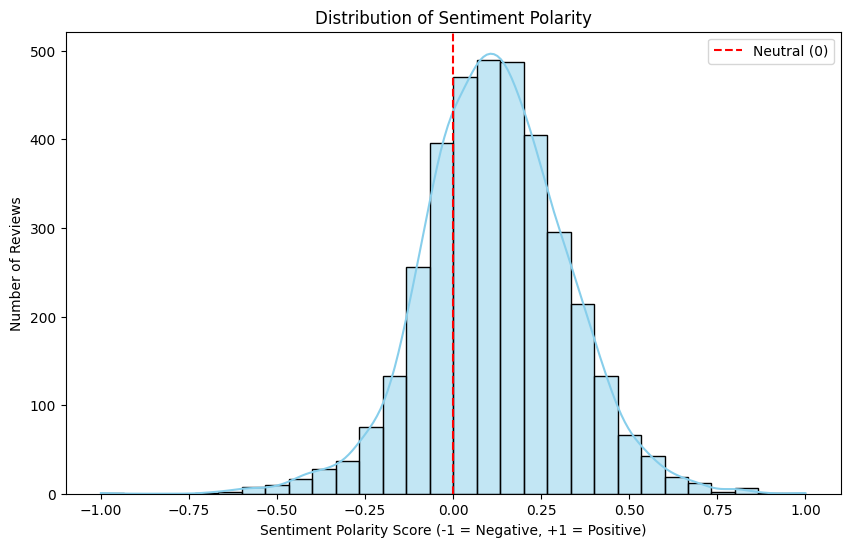

In [30]:
# Plotting the distribution of sentiment polarity
plt.figure(figsize=(10, 6))
sns.histplot(reviews_cleaned['sentiment_polarity'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Sentiment Polarity')
plt.xlabel('Sentiment Polarity Score (-1 = Negative, +1 = Positive)')
plt.ylabel('Number of Reviews')
plt.axvline(0, color='red', linestyle='--', label='Neutral (0)')
plt.legend()
plt.show()

In [31]:
# Map sentiment polarity to categories
def polarity_category(polarity):
    if polarity >= 0.25:
        return 'Positive'
    elif polarity <= -0.25:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the mapping function
reviews_cleaned['polarity_category'] = reviews_cleaned['sentiment_polarity'].apply(polarity_category)   

# Count the number of reviews in each polarity category
polarity_counts = reviews_cleaned['polarity_category'].value_counts()

polarity_counts

polarity_category
Neutral     2596
Positive     883
Negative     129
Name: count, dtype: int64

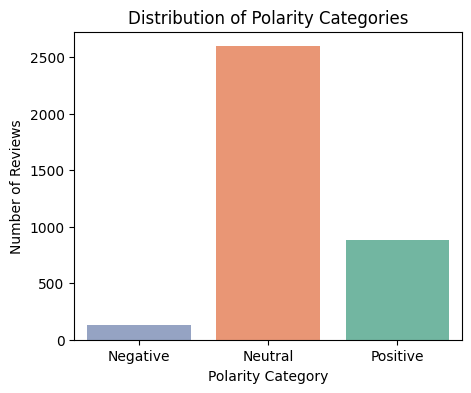

In [32]:
# Plot the polarity categories
plt.figure(figsize=(5, 4))
sns.countplot(x='polarity_category', data=reviews_cleaned, 
              palette='Set2', hue='polarity_category', 
              order=['Negative', 'Neutral', 'Positive'])
plt.title('Distribution of Polarity Categories')
plt.xlabel('Polarity Category')
plt.ylabel('Number of Reviews')
plt.show()

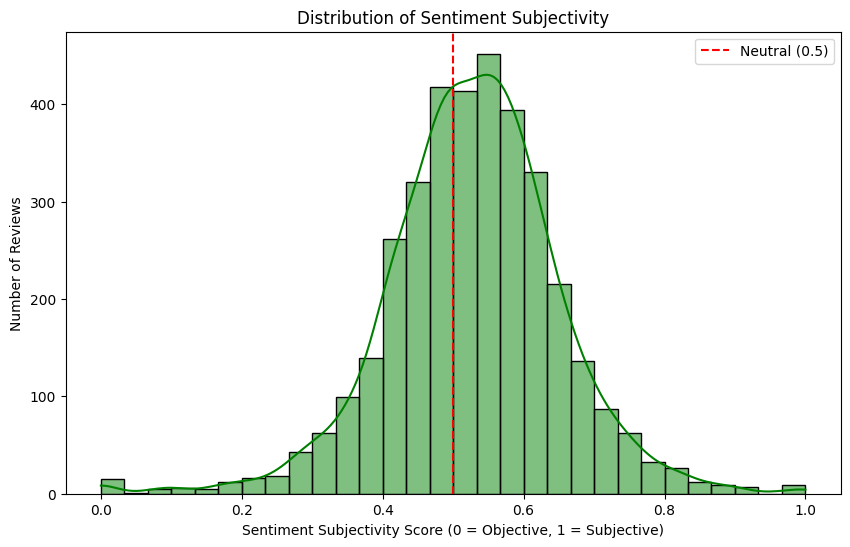

In [33]:
# Plotting the distribution of sentiment subjectivity
plt.figure(figsize=(10, 6))
sns.histplot(reviews_cleaned['sentiment_subjectivity'], bins=30, kde=True, color='green')
plt.title('Distribution of Sentiment Subjectivity')
plt.xlabel('Sentiment Subjectivity Score (0 = Objective, 1 = Subjective)')
plt.ylabel('Number of Reviews')
plt.axvline(0.5, color='red', linestyle='--', label='Neutral (0.5)')
plt.legend()
plt.show()

In [34]:
# Categorize subjectivity
def subjectivity_category(subjectivity):
    if subjectivity >= 0.65:
        return 'Subjective'
    elif subjectivity <= 0.35:
        return 'Objective'
    else:
        return 'Neutral'
    
# Apply the mapping function
reviews_cleaned['subjectivity_category'] = reviews_cleaned['sentiment_subjectivity'].apply(subjectivity_category)

# Count the number of reviews in each subjectivity category
subjectivity_counts = reviews_cleaned['subjectivity_category'].value_counts()
subjectivity_counts

subjectivity_category
Neutral       2904
Subjective     484
Objective      220
Name: count, dtype: int64

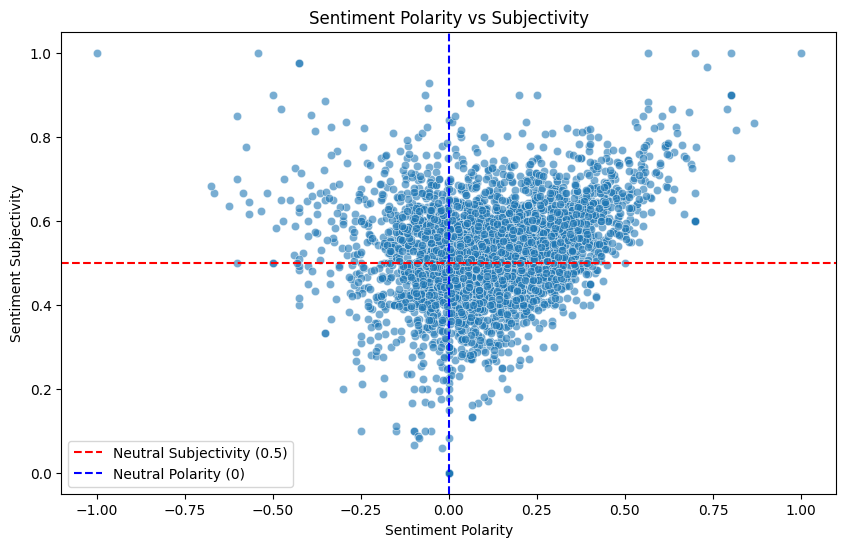

In [35]:
# Scatter plot of sentiment polarity vs subjectivity
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sentiment_polarity', y='sentiment_subjectivity', data=reviews_cleaned, alpha=0.6)
plt.title('Sentiment Polarity vs Subjectivity')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Sentiment Subjectivity')
plt.axhline(0.5, color='red', linestyle='--', label='Neutral Subjectivity (0.5)')
plt.axvline(0, color='blue', linestyle='--', label='Neutral Polarity (0)')
plt.legend()
plt.show()

### Sentiment Analysis Using VADER

In [36]:
# Apply VADER sentiment analysis and extract the compound score
reviews_cleaned['vader_sentiment'] = reviews_cleaned['lemmatized_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [37]:
# Comparing of Textblob and Vader polarity scores
sentiment_comparison = reviews_cleaned[['sentiment_polarity', 'vader_sentiment']].describe().round(2)
sentiment_comparison

,sentiment_polarity,vader_sentiment
count,3608.00,3608.00
mean,0.12,0.31
std,0.20,0.72
min,-1.00,-1.00
25%,-0.01,-0.42
50%,0.12,0.68
75%,0.25,0.94
max,1.00,1.00


🧠 **What This Tells Us:**

🔹 **Polarity (TextBlob vs. VADER)**

* **TextBlob Polarity (mean: 0.12)** shows the reviews are slightly positive on average, but not strongly so.
* **VADER Compound (mean: 0.31)** suggests a stronger lean toward **positive sentiment** than TextBlob.
* **VADER’s 75th percentile is 0.94** — this means a large number of reviews are classified as **very positive**, more than what TextBlob detects.
* **VADER’s wider standard deviation (0.72)** reflects that it’s capturing more **extreme sentiments** — both highly negative and highly positive.

✅ **Conclusion:**
**VADER is more expressive** in detecting emotional highs and lows in informal reviews. TextBlob tends to give more **conservative scores**.

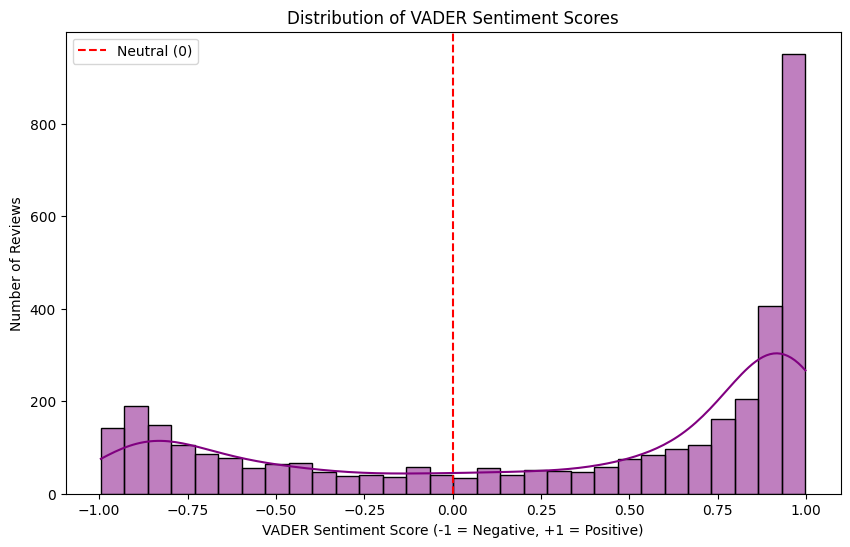

In [38]:
# Plotting the distribution of vadar sentiment
plt.figure(figsize=(10, 6))
sns.histplot(reviews_cleaned['vader_sentiment'], bins=30, kde=True, color='purple')
plt.title('Distribution of VADER Sentiment Scores')
plt.xlabel('VADER Sentiment Score (-1 = Negative, +1 = Positive)')
plt.ylabel('Number of Reviews')
plt.axvline(0, color='red', linestyle='--', label='Neutral (0)')
plt.legend()
plt.show()

In [39]:
# Categorize VADER sentiment scores
def vader_sentiment_category(score):
    if score >= 0.25:
        return 'Positive'
    elif score <= -0.25:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the mapping function
reviews_cleaned['vader_label'] = reviews_cleaned['vader_sentiment'].apply(vader_sentiment_category)

# Count the number of reviews in each VADER polarity category
vader_polarity_counts = reviews_cleaned['vader_label'].value_counts()
vader_polarity_counts    

vader_label
Positive    2253
Negative    1028
Neutral      327
Name: count, dtype: int64

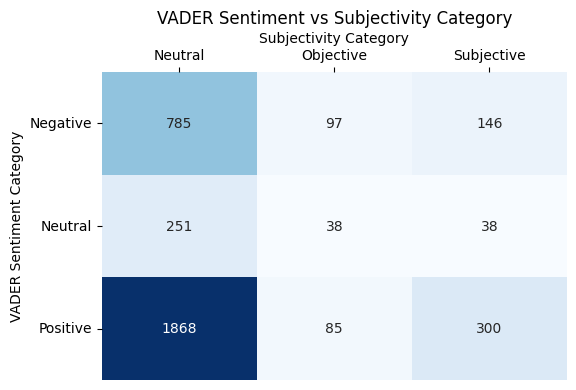

In [40]:
# Heatmap of vader sentiment vs TextBlob subjectivity
plt.figure(figsize=(6, 4))
sns.heatmap(pd.crosstab(reviews_cleaned['vader_label'], reviews_cleaned['subjectivity_category']),
            annot=True, fmt='d', cmap='Blues', cbar=False)

# Move x-axis labels to the top
plt.gca().xaxis.set_ticks_position('top')
plt.gca().xaxis.set_label_position('top')

plt.yticks(rotation=0)

plt.title('VADER Sentiment vs Subjectivity Category')
plt.xlabel('Subjectivity Category')
plt.ylabel('VADER Sentiment Category')
plt.show()

### Extracting Top 5 Reviews based on each sentiment category

In [41]:
pd.set_option('display.max_colwidth', None)

In [42]:
# 1. Top 5 most positive reviews based on vader sentiment
top_positive_reviews = reviews_cleaned.nlargest(5, 'vader_sentiment')[['reviews', 'vader_sentiment']]
top_positive_reviews['vader_sentiment'] = top_positive_reviews['vader_sentiment'].round(2)

print("Top 5 Most Positive Reviews:")
top_positive_reviews


Top 5 Most Positive Reviews:


,reviews,vader_sentiment
587,"I was supposed to fly with Aeroflot on the 23rd of December to Moscow. But because Russia has closed its borders, like the majority of other countries, the flight was canceled, and I couldn’t get home. I’ve also tried to fly through Antalya, but the same situation occurred. On my third try, I came to Heathrow and tried to fly away to Cairo. I was declined by another company. Then I went to British Airways. Starting from testing (because Egypt requires tests), as stressful as the whole situation was, the employees were outstanding! (I’m not sure is it connected to BA, but still, I want to mention this). The crew was very helpful and extremely understanding, very professional and urgent to help, they have been a great help and I am very gracious for this. I want to separately point out one employee - Shanell (if I am not mistaken, who works at Collision testing center in Heathrow Terminal 5). She is a savior and most importantly a human, which is very rare nowadays! Carrying on, I went to BA check-in, but unfortunately couldn’t do it, as my results didn’t go through yet. However, another outstanding employee who provided great help called her colleagues and arranged for the booking to be frozen until the results arrive. I’ve come to her 3 times with additional questions, and every time she was very patient, professional, and happy to help. After I got my results I came back to Heathrow on 24th, but unfortunately, there were no flights to Cairo, the situation became even more complicated (I will spare the details). However, here again, brilliant employees of BA offered their personal assistance and showed sympathy and humanity towards me. The nicest lady I’ve ever met, unfortunately, I didn’t catch her name, but I am aware it was her first day at BA and that she is Egyptian, followed me throughout my struggles, offered me emotional and professional support. She tried to find any possible ways for me to get back home and actually did. She was open to any kind of help and was enormously helpful for which I can’t thank her enough. She also asked her colleague to help me, which he kindly did. Lastly, the nice lady (shame I don’t know her name) also shared my struggles with her colleague Mani who came to substitute her on the position. He was very friendly and attentive as well, talked me through the process, offered different ways I can stay at the airport, gave his phone to call, and offered to drop me off at the hotel, which he did not have to do whatsoever. To conclude, I merely want to thank all of these individuals one more time, as they have been a great help both in physical and mental aspects, I honestly do not know what would I do if I haven’t met them. I don’t know was I just lucky to meet these people or all BA employees are of the same morality, but I do want to thank BA for hiring and providing jobs for these great human beings as well as upholding the standard for other airlines! For some people, the help that was provided to me might seem like a normal thing to do. However, for me, it was a pleasant and so much needed surprise. As no one in",1.0
1334,"London to Tel Aviv. Arrived at Heathrow at about 5pm expecting it to be very busy, but check and security felt like it was 10pm, very easy and quick process (which included regular rather than fast track security as we didn’t follow the signs properly). We used galleries south lounge and first impressions were actually pretty poor, although they did later improve. The food offering on arrival was a few sandwiches, soup and some dry cake. This wasn’t really acceptable at all although about an hour after we arrived the evening meals were laid out and there was a good selection of hot and cold dishes which were quite tasty. Drinks overall were good as always with British Airways although champagne is only served on request and the quality of the one provided was really quite appalling. In terms of seating, there was enough for all the passengers

In [43]:
# 2. Top 5 most negative reviews based on vader sentiment
top_negative_reviews = reviews_cleaned.nsmallest(5, 'vader_sentiment')[['reviews', 'vader_sentiment']]
top_negative_reviews['vader_sentiment'] = top_negative_reviews['vader_sentiment'].round(2)

print("Top 5 Most Negative Reviews:")
top_negative_reviews

Top 5 Most Negative Reviews:


,reviews,vader_sentiment
768,"Hong Kong to Copenhagen via London. The whole experience is a nightmare to me and my wife. My wife lost her luggage ever since the first day of our journey on 1st August because our two pieces of luggage were left in Heathrow Airport by BA staff when we took the transit flight from the UK to Copenhagen. We went to Menzies in CPH and they filed a repor. We stated in the missing report that if the luggage was found, they should be sent to our air b&b house in Marstal in CPH on or before 3rd August or deliver to the hotel we stayed in CPH if they were found on 4th August. On 2nd August, we found that the updated status of our missing luggage in the BA website showed that one of our luggage was found while another one had a possible match. Therefore, we kept phoning and emailing Menzies staff to urge them to send the luggage to our house but they failed to do so. And the website status showed that we chose to pick up the luggage in the airport, which was not our preference but we failed to change the preference on the website as it was preset. The system even changed the latest delivery date to 3th August 2020 instead of 2019 and we could not correct it by ourselves! On 3rd August, Menzies staff still failed to deliver the luggage to us so we told them we decided to pick them up at the airport. Unfortunately, when we went to the CPH airport on the 4th August, they told us that they had already sent the 'found' luggage to the island in Marstal on 4th. Apparently they did not follow our instructions and sent it to the wrong place on the wrong date. They then asked us to find the other luggage that had been scanned with a possible match randomly in the trolleys outside their office. We did find the other one by ourselves in the airport, which they claimed had been sent to the island but they insisted that it was the possible match one! They were so incompetent and even asked us to complain to the BA to push them to find the baggage for us. We believe that the baggage was the one which was sent to the island but is still missing but the staff messed it up. We were so confused which bag was really missing. We finally decided to ask them to deliver the luggage in Marstal to the airport and send it to the UK address which was our next destination. When we came back to the hotel in the evening on the 4th, we phoned Menzies again and found out that our luggage in Marstal had been sent back to the airport at 8 pm on the 4th. Hence, we decided to pick it up by ourselves on the 5th August before we flew to the UK. However, when we came to the airport again, we couldn't find our luggage and the staff didn't explain why and just told us to leave. If the luggage was sent it to the airport on the 4th, how come it would disappear on the 5th? The staff just kept saying that they were busy and that no one had time to look for the baggage for us. This service was totally unacceptable. We spnet hours parking at the airport and found that we got nothing! You can't imagine how furious and frustrated we were! We are literally sick of phoning Menzies staff every day and not getting anywhere. Now that Menzies staff asked us to pressure BA to in turn pressure them to locate our luggage. That's how ridiculous things have been for us. We are sure that you could do something about it. My wife has lost all her personal belongings since day 1 of our trip.",-1.00
1453,"Toulouse to London Heathrow. This airline will one day get its comeuppance for posing as a quality flag carrier (it has to be said, no expense is spared on its branding) while operating as a cheap and sleazy budget airline, thanks to the rationale of its greedy and cynical new management. I have Bronze status with BA Executive Club, have flown a dozen times over the past year (both in Business and in Economy) and am increasingly irritated with myself that I chose to collect points with this particular airline. I was caught up in the IT meltdown in May (flying from Rhod

In [44]:
# 3. Top 5 most neutral reviews based on vader sentiment
top_neutral_reviews = reviews_cleaned.iloc[(reviews_cleaned['vader_sentiment'] - 0).abs().argsort()[:5]][['reviews', 'vader_sentiment']]
top_neutral_reviews['vader_sentiment'] = top_neutral_reviews['vader_sentiment'].round(2)

print("Top 5 Most Neutral Reviews:")
top_neutral_reviews

Top 5 Most Neutral Reviews:


,reviews,vader_sentiment
391,"British Airways is late, their website is atrocious, and they wouldn't let me check-in until 24 hours before the flight. I have been trying for 6 hours to check in through their website, and/or find a real person to speak with. Customer service had such a thick accent I didn't think they were speaking English.",0.0
2850,"FRA-LHR on A319, We sat on the plane at the gate for almost 40 minutes due to one runway closed, no drinks offered. No veg meal for my wife, Empty bottle under the middle seat tray. Landed allegedly almost on time due to the excessive time scheduled for the leg.",0.0
2962,Substandard food in Business Class (London to Mauritius) arbitrary upgrade policy - as we could not afford Bus Class on return flight booked Premium Economy we told that because we were Bus on way out we would get priority consideration on way back. Charging for Seat selection is a rip off was separated from my wife on way out!,0.0
2980,Return LHR-YVR Boeing 747-400. I had been advised to fly BA but unfortunately I ended up very disappointed with the return leg. My seat was double booked so they eventually got me one but the entertainment system was not working! When I asked about it she said it had not been working yesterday either. No other vacant seats in economy but there were loads in business class but would not upgrade me. 10hr flight with nothing. Definitely would not fly with them again.,0.0
1187,"Gatwick to Barbados in December 2017. On a 9 hour flight they provided one meal, and afternoon tea which consisted of a mars bar and a cup of tea. The plane was aging and yellowing round the edges and the staff were surly. The only redeeming thing was that it was cheaper than competitors (but still not cheap).",0.0


In [45]:
# 4. Top 5 most subjective reviews based on TextBlob subjectivity
top_subjective_reviews = reviews_cleaned.nlargest(5, 'sentiment_subjectivity')[['reviews', 'sentiment_subjectivity']]
top_subjective_reviews['sentiment_subjectivity'] = top_subjective_reviews['sentiment_subjectivity'].round(2)

print("Top 5 Most Subjective Reviews:")
top_subjective_reviews

Top 5 Most Subjective Reviews:


,reviews,sentiment_subjectivity
2,"Terrible experience. No respect to priority boarding, crowded buses to take us to plane, without to mention the waiting time we had to wait inside the switched off bus with NO air conditioning.",1.0
591,"Boarding and checkin formalities are very nice. Check in help desk was very helpful and supportive. Everything was nice except food. I am vegan and there was no food availability for vegetarian passengers if not pre-ordered. My flight was 10 hour journey from London to Bangalore, and I was hungry.",1.0
698,"Los Angeles to Amsterdam via London. Due to delayed take off I risked missing my connecting flight. Thanks to the excellent premium host service, Julie and her colleague, I managed to be on time! Thank you very much.",1.0
871,"Vancouver to London, we were upgraded to business class at the airport. The staff were absolutely delightful and had a fabulous trip. Really they could not have been more helpful and I would recommend them.",1.0
1577,"Geneva to Dallas via Heathrow. I checked online and confirmed I had two bags of allowance to check in with my premium economy seat purchased. However, when I went to the airport to check in the luggage BA insisted that I only had one bag allowance and I had to pay. I had no other choice so I paid. I checked with BA in Heathrow and they confirmed I had two bags. Now I will have to go through sending the customer service a letter to get a refund. Not happy that their system is not in coordinance with each other.",1.0


In [46]:
# 6. Top 5 most objective reviews based on TextBlob subjectivity
top_objective_reviews = reviews_cleaned.nsmallest(5, 'sentiment_subjectivity')[['reviews', 'sentiment_subjectivity']]
top_objective_reviews['sentiment_subjectivity'] = top_objective_reviews['sentiment_subjectivity'].round(2)

print("Top 5 Most Objective Reviews:")
top_objective_reviews

Top 5 Most Objective Reviews:


,reviews,sentiment_subjectivity
31,"British airways lost bags in LHR then found them. Sent to Cologne where it sat for two days before they told me, but no one was there to give it to me. I spent 10 days in Europe without a bag, bought clothes. BA refused to reimburse me. They closed the case 10 days after i returned to the states when my bag showed up at my front door. They wont let you talk to management, they say they email mail you but they don't then you call customer service. they say they will escalate it but you will never know. they don't update the claims or the forms.",0.0
74,"Flight changed just one day before from British Airways to Titan. Flight delayed 2 hours. No meal served, and no entertainment. Again the flight changed to Titan for the way back.",0.0
236,"In June my flight was cancelled within three hours of departure. Was given a rebooking the next day and they lost my suitcase. It arrived three days later. Today - 25th August 2023 - it happened again. Offer of rebooking in two days. When trying to post a claim, the website doesn't work. Never again, BA.",0.0
264,Came from Glasgow to London and took connecting flight American Airlines from London to North Carolina. It's my third day here in North Carolina and still waiting for my luggage. They didn't even bother to transfer the luggage to connecting flight. Luggage are still in Glasgow.,0.0
558,"No check in staff for Economy. Never experienced this before. While Business passengers strolled up, Economy passengers were left standing for 90 mins plus.",0.0


## 2. Bag of Words and Word Frequency

### WordCloud to Identify Most Common words

In [47]:
# Combine all the reviews into one text
all_reviews = ' '.join(reviews_cleaned['lemmatized_text'])

# Tokenize the combined text into words
all_tokens = all_reviews.split()

# Count the frequency of each word
word_freq = Counter(all_tokens)

# View the 10 most common words
print("Most Common Words:", word_freq.most_common(10))

Most Common Words: [('flight', 7763), ('ba', 4730), ('seat', 4603), ('service', 2937), ('time', 2417), ('good', 2394), ('fly', 2388), ('food', 2323), ('crew', 2235), ('london', 2134)]


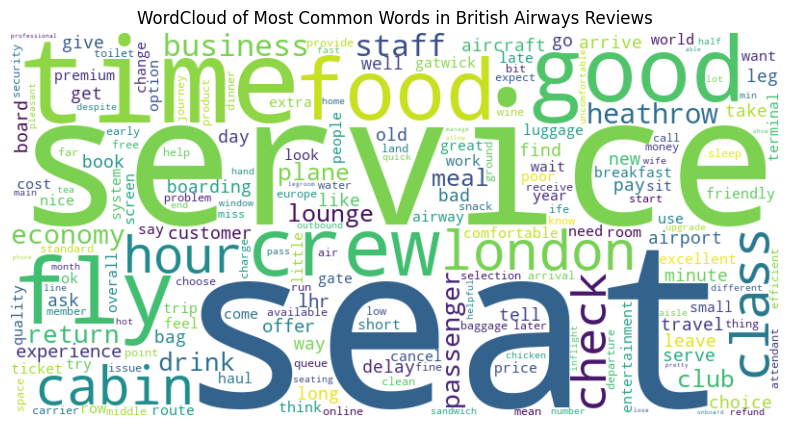

In [48]:
# Customize the stopwords
custom_stopwords = {'british', 'airways', 'flight', 'ba', 'airline'} 
filtered_freq = {word: freq for word, freq in word_freq.items() if word not in custom_stopwords}

# Create WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white', 
                      colormap='viridis', max_words=200).generate_from_frequencies(filtered_freq)
# Display the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of Most Common Words in British Airways Reviews')
plt.show()

### TF-IDF with Sentiment Analysis

In [49]:
# Add custom stopwords to the default English stopwords
custom_stopwords = list(default_stopwords.union({'british', 'airways', 'ba', 'airline',
                                                 'flight', 'aircraft', 'fly'}))

In [50]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words=custom_stopwords)

In [51]:
# Group by vader sentiment category and aggregate reviews
grouped_reviews = reviews_cleaned.groupby('vader_label')['lemmatized_text'].apply(lambda x: ' '.join(x))

In [52]:
# Fit and transform the grouped reviews
tfidf_matrix = tfidf_vectorizer.fit_transform(grouped_reviews)

# Convert to DataFrame for better readability
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), 
                        index=grouped_reviews.index, 
                        columns=tfidf_vectorizer.get_feature_names_out())

In [53]:
tfidf_df.head()

,aa,able,absolute,absolutely,accept,acceptable,access,accommodate,actually,add,...,world,worth,wrap,write,wrong,year,yes,york,young,zero
vader_label,,,,,,,,,,,,,,,,,,,,,
Negative,0.005482,0.016142,0.007919,0.018274,0.010355,0.005787,0.008528,0.001523,0.014619,0.013096,...,0.040811,0.009137,0.004264,0.010355,0.024974,0.059085,0.004873,0.008223,0.006396,0.007309
Neutral,0.003174,0.029628,0.002116,0.010581,0.005291,0.006349,0.012698,0.004233,0.016930,0.007407,...,0.044441,0.014814,0.006349,0.012698,0.010581,0.049732,0.008465,0.005291,0.003174,0.001058
Positive,0.004678,0.018712,0.002782,0.008218,0.006322,0.009356,0.014034,0.003540,0.016183,0.008724,...,0.061446,0.019723,0.002276,0.005816,0.006827,0.051837,0.006954,0.007460,0.009103,0.002149


In [54]:
# View the Top 10 TF-IDF features for each sentiment category
for sentiment in grouped_reviews.index:
    print(f"\nTop 10 TF-IDF features for {sentiment} reviews:")
    top_features = tfidf_df.loc[sentiment].nlargest(10)
    print(top_features) 


Top 10 TF-IDF features for Negative reviews:
seat        0.355118
service     0.254918
hour        0.218066
london      0.211975
time        0.179691
class       0.178473
food        0.158372
business    0.148930
delay       0.147408
staff       0.145580
Name: Negative, dtype: float64

Top 10 TF-IDF features for Neutral reviews:
seat       0.417960
service    0.234904
time       0.198928
hour       0.180940
london     0.177765
food       0.175649
check      0.160835
crew       0.158719
cabin      0.157661
staff      0.146021
Name: Neutral, dtype: float64

Top 10 TF-IDF features for Positive reviews:
seat       0.384607
good       0.265761
service    0.237440
crew       0.212785
time       0.207222
food       0.206970
cabin      0.184085
london     0.160569
class      0.156523
check      0.132375
Name: Positive, dtype: float64


📊 **TF-IDF Keyword Insights by Sentiment**

To uncover more meaningful patterns beyond raw word frequency, TF-IDF was applied to the cleaned reviews. This highlights **distinctive keywords** that are especially important within each sentiment category — revealing what travelers emphasize when they’re happy, dissatisfied, or indifferent.

---

🔴 **Negative Reviews**

In negative reviews, words like **"seat"**, **"service"**, and **"delay"** stood out with high TF-IDF scores — *seat* alone had the highest emphasis across all sentiment groups. Complaints often focused on **long delays**, **uncomfortable seats**, and underwhelming **business class** experiences. Terms like *London*, *staff*, and *hour* also appeared frequently, suggesting logistical frustrations and poor customer interaction, particularly for premium passengers.

---

🟡 **Neutral Reviews**

Neutral reviews, while less emotionally charged, still revolved around practical elements like **"seat"**, **"service"**, **"check"**, and **"time"**. These reviews tend to describe experiences factually, often mentioning boarding, timing, and general expectations without strong praise or criticism. The appearance of both *crew* and *food* hints at balanced assessments — where things may not have been excellent, but also not problematic.

---

🟢 **Positive Reviews**

In contrast, positive reviews were rich with affirmations like **"good"**, **"crew"**, and **"food"**, alongside consistently frequent terms such as *seat* and *service*. Travelers in this category appreciated smooth flights, professional crew, and in some cases, premium cabin experiences. Interestingly, even in positive reviews, mentions of *London* and *check* surfaced — indicating that while the overall experience was satisfying, some key logistical touchpoints remain memorable across sentiments.

---

🧠 **Overall Takeaway**

* **“Seat” and “service”** are the most talked-about aspects across all sentiment types, showing up consistently but with different emotional tones.
* **Negative reviews** highlight operational issues and premium dissatisfaction.
* **Neutral reviews** reflect more factual, mixed experiences without emotional extremes.
* **Positive reviews** focus on friendliness, comfort, and well-executed service — with *crew* and *good* strongly associated.

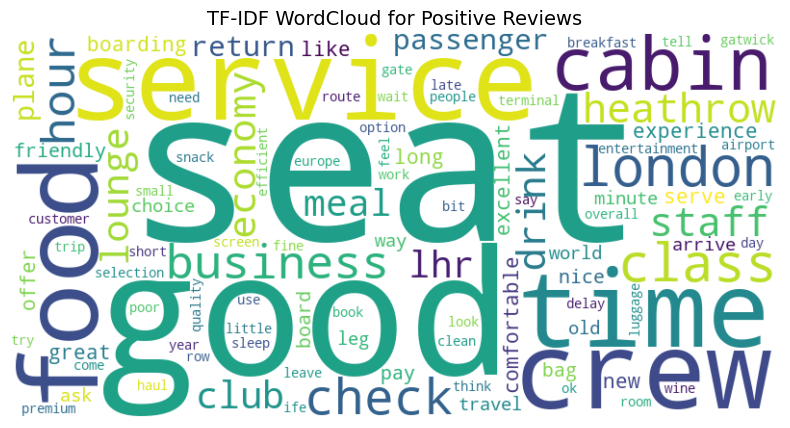

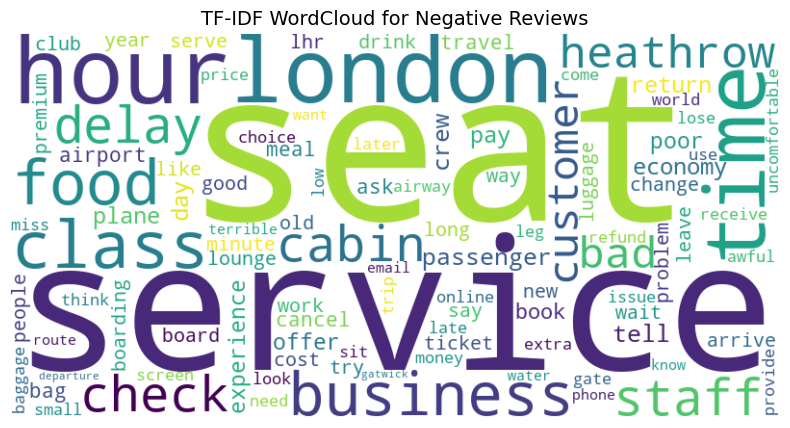

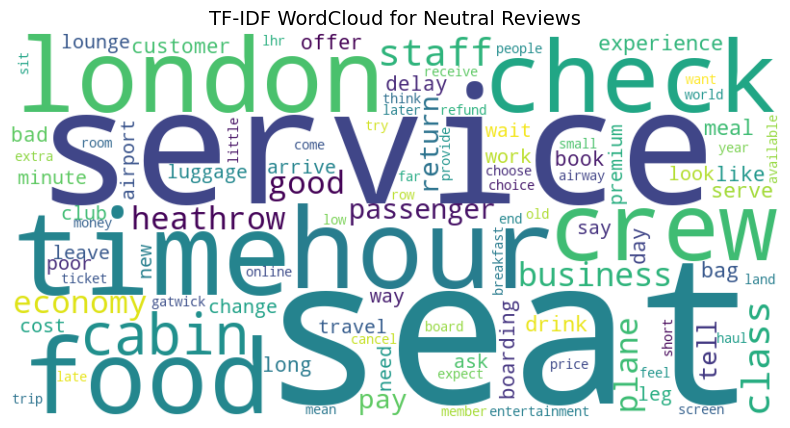

In [55]:
# Function to plot TF-IDF word cloud for a given sentiment label
def plot_tfidf_wordcloud(sentiment_label, max_words=100):
    tfidf_scores = tfidf_df.loc[sentiment_label]
    word_freq = tfidf_scores.sort_values(ascending=False).to_dict()
    
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                          max_words=max_words).generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"TF-IDF WordCloud for {sentiment_label} Reviews", fontsize=14)
    plt.show()

# Plot TF-IDF word clouds for each sentiment category
plot_tfidf_wordcloud("Positive")
plot_tfidf_wordcloud("Negative")
plot_tfidf_wordcloud("Neutral")


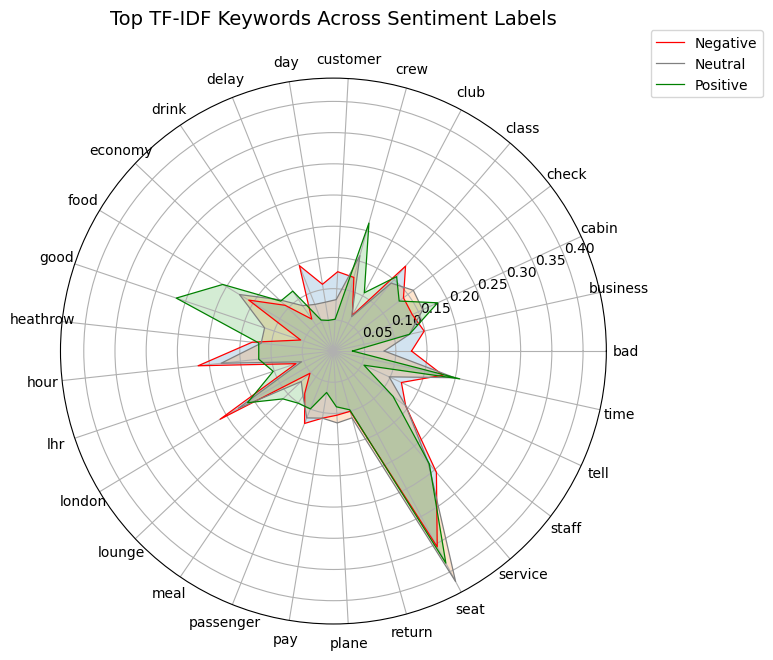

In [56]:
# Step 1: Select common or top words across all sentiments
# Here, we select top from each and take the union
top_words = set()
for sentiment in tfidf_df.index:
    top_words |= set(tfidf_df.loc[sentiment].sort_values(ascending=False).head(20).index)

# Make sure ordering is consistent
top_words = sorted(top_words)

# Step 2: Prepare data for radar plot
labels = top_words
num_vars = len(labels)

# Get the values for each sentiment
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # complete the loop

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Define custom color map
sentiment_colors = {
    'Negative': 'red',
    'Neutral': 'grey',
    'Positive': 'green'
}

# Plot each sentiment
for sentiment in tfidf_df.index:
    values = tfidf_df.loc[sentiment][labels].tolist()
    values += values[:1]  # complete the loop
    color = sentiment_colors.get(sentiment, 'blue')  # default to blue if not found
    ax.plot(angles, values, label=sentiment, color=color, linewidth=0.9)
    ax.fill(angles, values, alpha=0.2)

# Add labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=10)
ax.set_title("Top TF-IDF Keywords Across Sentiment Labels", fontsize=14, pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()


🕸️ **TF-IDF Keyword Patterns Across Sentiment Labels (Radar Chart Insight)**

This radar chart highlights how the **importance of key review terms** varies across sentiment categories based on their TF-IDF scores.

**"Seat"** emerges as a dominant topic across all sentiments, confirming it as a central aspect of the customer experience — regardless of whether reviews are positive, neutral, or negative.

In **positive reviews**, keywords like **"crew"** and **"good"** rank highly, indicating that **staff behavior** and **overall satisfaction** are strong contributors to favorable opinions.

Conversely, **negative reviews** are more strongly associated with words such as **"delay"**, **"heathrow"**, **"hour"**, and **"lhr"** — clearly pointing to frustrations with **flight punctuality** and **airport experiences**.

Terms like **"check"**, **"service"**, and **"business"** appear more evenly across all sentiment categories, showing they are frequently mentioned but not uniquely tied to one emotional tone.

The presence of **"meal"**, **"drink"**, and **"club"** also points to references about **in-flight service and premium cabin experiences**, contributing to both **positive** and **neutral** feedback.

🧠 **Key Takeaway**:
TF-IDF analysis through radar visualization reveals both **universal themes** (e.g. seat and service) and **sentiment-specific drivers** (e.g. delays for negative reviews, crew quality for positive ones). These insights can help British Airways **prioritize improvements** and **reinforce service elements** that matter most to travelers.

## 3. **Topic Modeling: Uncovering Key Themes in British Airways Reviews**

To better understand the **underlying themes** in the reviews, I applied **Latent Dirichlet Allocation (LDA)** — a popular topic modeling technique that helps group similar reviews based on common keywords and discussion patterns.

🎯 **Goal of This Step:**

Identify the **main themes** customers discuss in their reviews — both positive and negative — without needing predefined labels. This helps reveal the topics that matter most to customers and how frequently they occur.

🧩 **Optimal Model Selection**

After evaluating multiple LDA models with different topic numbers (ranging from 2 to 10), the **3-topic model** was selected based on its **highest coherence score (0.3984)**, indicating strong and distinct topic separation.

📋 **Identified Topics & Interpretation**

| **Topic #** | **Label**                                | **Keywords (Top 10)**                                                           | **Theme Description**                                                                    |
| ----------- | ---------------------------------------- | ------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------------- |
| **1**       | *Operational Issues & Ground Experience* | hour, check, tell, british, delay, time, london, service, staff, airways        | Reviews mentioning **delays**, **check-in struggles**, and **customer service issues**   |
| **2**       | *Cabin Class & Flight Features*          | fly, british, airline, food, class, service, airways, business, london, economy | Focuses on **flight class experience**, **food**, and **general airline quality**        |
| **3**       | *Positive Experience & Premium Comfort*  | good, crew, cabin, food, service, time, club, lounge, lhr, drink                | Highly **positive tone** about **crew**, **club lounges**, **Heathrow**, and **service** |

📊 **What This Tells Us:**

* **Topic 1** captures frustrations around **operational reliability** — a clear area for British Airways to improve.
* **Topic 2** shows that **food, class, and branding** are frequently discussed and may influence mixed sentiment.
* **Topic 3** highlights **customer satisfaction**, especially among **premium-class or lounge-access passengers**.

These insights are invaluable for guiding **service improvements**, **marketing communication**, and **customer experience strategies**.


In [57]:
# Step 1: Tokenize the lemmatized text for LDA
reviews_cleaned['tokens'] = reviews_cleaned['lemmatized_text'].apply(lambda x: x.split())

In [58]:
# Step 2: Create a dictionary and corpus 

# Create a dictionary from the tokens
id2word = corpora.Dictionary(reviews_cleaned['tokens'])

# Filter out extremes
id2word.filter_extremes(no_below=5, no_above=0.5)

# Create a corpus
corpus = [id2word.doc2bow(tokens) for tokens in reviews_cleaned['tokens']]

In [59]:
# Step 3a: Determine the optimal number of topics using Coherence Score
coherence_scores = []
model_list = []
num_topics_range = range(2, 11)  # Testing from 2 to 10 topics

for num_topics in num_topics_range:
    # Train LDA model
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=id2word, passes=10, random_state=42)
    model_list.append(lda_model)
    
    # Calculate coherence score
    coherence_model = CoherenceModel(model=lda_model, texts=reviews_cleaned['tokens'], dictionary=id2word, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)

In [60]:
print("Coherence Scores for different number of topics:")
for num_topics, score in zip(num_topics_range, coherence_scores):
    print(f"Number of Topics: {num_topics}, Coherence Score: {score:.4f}")

Coherence Scores for different number of topics:
Number of Topics: 2, Coherence Score: 0.3807
Number of Topics: 3, Coherence Score: 0.3984
Number of Topics: 4, Coherence Score: 0.3737
Number of Topics: 5, Coherence Score: 0.3880
Number of Topics: 6, Coherence Score: 0.3784
Number of Topics: 7, Coherence Score: 0.3774
Number of Topics: 8, Coherence Score: 0.3941
Number of Topics: 9, Coherence Score: 0.3903
Number of Topics: 10, Coherence Score: 0.3861


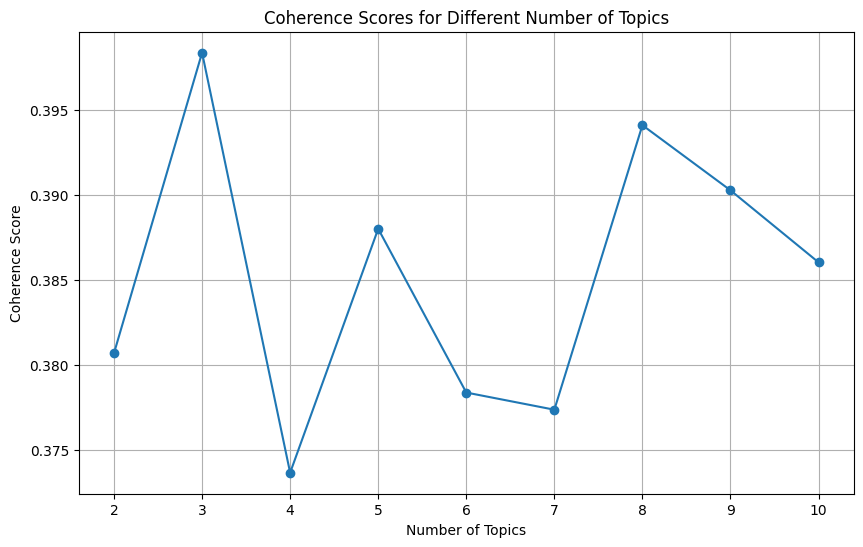

In [61]:
# Step 3b: Plot the coherence scores to find the optimal number of topics
plt.figure(figsize=(10, 6))
plt.plot(num_topics_range, coherence_scores, marker='o')
plt.title('Coherence Scores for Different Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.xticks(num_topics_range)
plt.grid()
plt.show()

In [62]:
# Step 4: Selecting final model based on coherence score
final_model = model_list[1]

# Show topics
for idx, topic in final_model.print_topics(-1):
    print(f"Topic {idx + 1}: {topic}")

Topic 1: 0.015*"hour" + 0.014*"check" + 0.011*"tell" + 0.011*"british" + 0.010*"delay" + 0.010*"time" + 0.010*"london" + 0.010*"service" + 0.009*"staff" + 0.009*"airways"
Topic 2: 0.018*"fly" + 0.016*"british" + 0.015*"airline" + 0.014*"food" + 0.014*"class" + 0.013*"service" + 0.012*"airways" + 0.011*"business" + 0.011*"london" + 0.010*"economy"
Topic 3: 0.020*"good" + 0.017*"crew" + 0.013*"cabin" + 0.013*"food" + 0.013*"service" + 0.012*"time" + 0.010*"club" + 0.010*"lounge" + 0.009*"lhr" + 0.009*"drink"


### Topic Distribtion

In [63]:
# Assign dominant topic to each review
def get_dominant_topic(lda_model, corpus):
    dominant_topics = []
    for doc in corpus:
        topic_probs = lda_model.get_document_topics(doc)
        dominant_topic = max(topic_probs, key=lambda x: x[1])[0] if topic_probs else None
        dominant_topics.append(dominant_topic)
    return dominant_topics

# Assign dominant topic
reviews_cleaned['dominant_topic'] = get_dominant_topic(final_model, corpus)

In [64]:
# Map topic numbers to descriptive labels
topic_labels = {
    0: 'Operational Issues',
    1: 'Cabin & Flight Features',
    2: 'Positive Experience'
}

reviews_cleaned['topic_label'] = reviews_cleaned['dominant_topic'].map(topic_labels)

In [65]:
reviews_cleaned['topic_label'].value_counts()

topic_label
Positive Experience        1527
Cabin & Flight Features    1109
Operational Issues          972
Name: count, dtype: int64

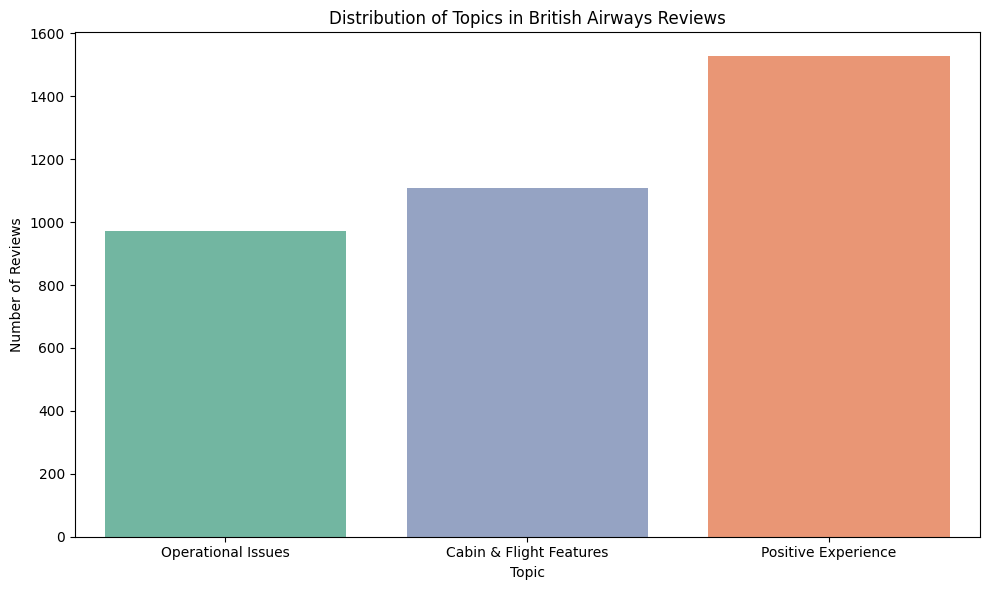

In [66]:
# Plotting the distribution of topics
plt.figure(figsize=(10, 6))
sns.countplot(x='topic_label', data=reviews_cleaned, 
              order=topic_labels.values(), 
              palette='Set2', hue='topic_label')
plt.title('Distribution of Topics in British Airways Reviews')
plt.xlabel('Topic')
plt.ylabel('Number of Reviews')
#plt.legend(title='Topic', loc='upper left')
plt.tight_layout()
plt.show()

🧠 **Topic Distribution – What Customers Talk About Most**

| Topic                       | Number of Reviews | % of Total |
| --------------------------- | ----------------- | ---------- |
| **Positive Experience**     | 1,527             | 42.1%      |
| **Cabin & Flight Features** | 1,109             | 30.5%      |
| **Operational Issues**      | 972               | 26.8%      |
| **Total**                   | 3,608             | 100%       |

💡 **What This Tells Us:**

* **Positive Experience** is the most dominant theme, showing that a large share of customers share praise — often highlighting service, crew, or food.
* **Cabin & Flight Features** like seating, club class, and entertainment also feature prominently.
* **Operational Issues**, including delays, cancellations, and communication breakdowns, still make up over a quarter of the reviews and **signal areas that may need improvement**.

### Sentiment Analysis per Topic

This helps answer:

> *"Are people generally positive or negative within each topic?"*

In [67]:
# Group reviews by topic and aggregate vader sentiment scores
sentiment_by_topic = (reviews_cleaned.groupby('topic_label')['vader_sentiment']
                      .agg(mean_polarity= 'mean',
                           total_reviews= 'count')
                      .round(2)
                      .sort_values(by='mean_polarity', ascending=False)
)

# Display the sentiment by topic
print("Sentiment by Topic:")
sentiment_by_topic

Sentiment by Topic:


,mean_polarity,total_reviews
topic_label,,
Positive Experience,0.74,1527
Cabin & Flight Features,0.10,1109
Operational Issues,-0.13,972


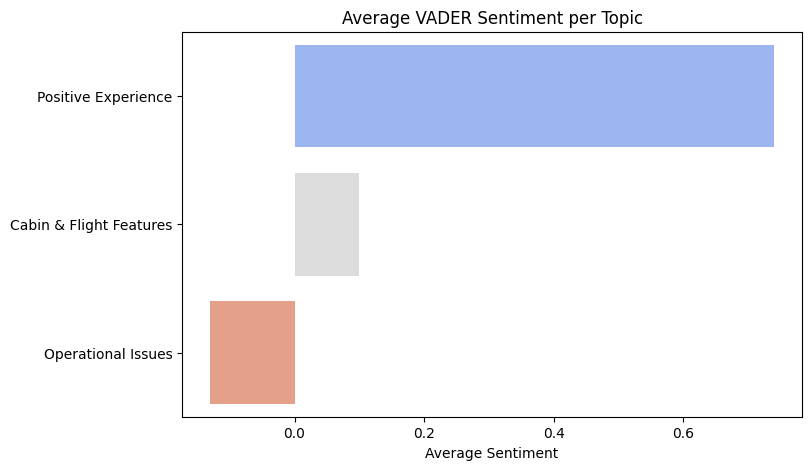

In [68]:
# Plotting
plt.figure(figsize=(8, 5))
sns.barplot(x='mean_polarity', y=sentiment_by_topic.index, 
            data=sentiment_by_topic.reset_index(), 
            palette='coolwarm', hue=sentiment_by_topic.index)
plt.title('Average VADER Sentiment per Topic')
plt.xlabel('Average Sentiment')
plt.ylabel('')
plt.show()

🧠 **What This Tells Us:**

🔹 **Positive Experience**
With a **very high average sentiment score of +0.74**, this topic clearly reflects strong customer satisfaction. Common praise includes **great crew service, smooth experiences, and comfort**, reinforcing British Airways’ positive reputation when expectations are met or exceeded.

🔹 **Cabin & Flight Features**
Sitting close to **neutral at +0.10**, this topic captures **mixed opinions**. While some passengers enjoy the **seats, meals, and check-in experience**, others express disappointment. This suggests opportunities for **experience consistency** across routes and cabins.

🔹 **Operational Issues**
Unsurprisingly, this cluster has a **negative average sentiment of –0.13**, dominated by frustration over **delays, cancellations, and airport logistics (e.g. LHR issues)**. It's a clear indicator of **pain points** that customers repeatedly raise.


✅ Why This Matters:

This analysis adds emotional context to the topics, helping British Airways prioritize:

* **Sustaining service excellence** in already high-performing areas
* **Reinforcing or redesigning** cabin features where customer feedback is lukewarm
* **Urgently addressing operational shortcomings** impacting reputation and loyalty

### pyLDAvis – Interactive Topic Explorer

In [69]:
# Prepare the visualization
lda_vis_data = gensimvis.prepare(final_model, corpus, id2word)

In [70]:
pyLDAvis.enable_notebook()
pyLDAvis.display(lda_vis_data)

In [71]:
# Save a html
#ldavis_path = base_dir / "lda_british_airways.html"
#pyLDAvis.save_html(lda_vis_data, str(ldavis_path))

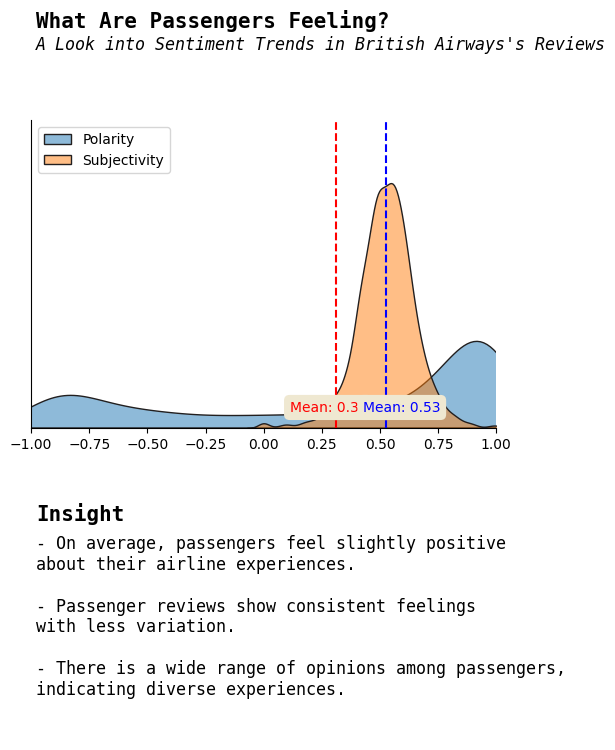

In [72]:
# Visualizing the Polarity and Subjectivity Distribution

plt.figure(figsize=(6, 4))

# Density plots
sns.kdeplot(reviews_cleaned['vader_sentiment'], fill=True, alpha=0.5, edgecolor='#221f1f')
sns.kdeplot(reviews_cleaned['sentiment_subjectivity'], fill=True, alpha=0.5, edgecolor='#221f1f')

# Setting x-axis and y-axis limits
plt.xlim(-1, 1)
plt.ylim(0, 4.5)

# Removing y-axis ticks and labels
plt.tick_params(left=False, labelleft=False)

# Removing ticks and spines
plt.tick_params(left=False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Remove x and y axis labels
plt.xlabel('')
plt.ylabel('')

# Calculate and plot mean lines
mean_polarity = reviews_cleaned['vader_sentiment'].mean()
mean_subjectivity = reviews_cleaned['sentiment_subjectivity'].mean()
plt.axvline(x=mean_polarity, color='red', linestyle='--')
plt.axvline(x=mean_subjectivity, color='blue', linestyle='--')

# Annotate mean values with a box
plt.text(mean_polarity - 0.2, 0.3, f'Mean: {mean_polarity:.2f}', color='red', va='center',
         bbox=dict(boxstyle='round', pad=0.4, facecolor='#efe8d1', linewidth=0, edgecolor='none'))
plt.text(mean_subjectivity - 0.1, 0.3, f'Mean: {mean_subjectivity:.2f}', color='blue', va='center',
         bbox=dict(boxstyle='round', pad=0.4, facecolor='#efe8d1', linewidth=0, edgecolor='none'))

# Adding title and subtitle
plt.text(0.01, 1.3, 'What Are Passengers Feeling?',
         fontsize=15, fontweight='bold', fontfamily='monospace', transform=plt.gca().transAxes)
plt.text(0.01, 1.23, "A Look into Sentiment Trends in British Airways's Reviews",
         fontsize=12, fontweight='light', fontfamily='monospace',
         fontdict={'fontstyle': 'italic'}, transform=plt.gca().transAxes)

# Adding legends
plt.legend(['Polarity', 'Subjectivity'])

# Adding texts for insights
plt.text(0.01, -0.3, 'Insight',
         fontsize=15, fontweight='bold', fontfamily='monospace', transform=plt.gca().transAxes)

plt.text(0.01, -1, '''
- On average, passengers feel slightly positive
about their airline experiences.

- Passenger reviews show consistent feelings
with less variation.

- There is a wide range of opinions among passengers,
indicating diverse experiences.

        ''', fontsize=12, fontweight='light', fontfamily='monospace', transform=plt.gca().transAxes)

#plt.tight_layout()
plt.show()

In [ ]:
# Save the dataset
# save the final dataset to a new CSV file
final_reviews_path = base_dir / "data" / "british_airways_reviews_final.csv"
#reviews_cleaned.to_csv(final_reviews_path, index=False)